In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

# 设置要打印的文件数量
num_files_to_print = 10
counter = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        counter += 1
        if counter >= num_files_to_print:
            break
    if counter >= num_files_to_print:
        break
#import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
 #       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/isic-2024-challenge/sample_submission.csv
/kaggle/input/isic-2024-challenge/train-metadata.csv
/kaggle/input/isic-2024-challenge/test-metadata.csv
/kaggle/input/isic-2024-challenge/test-image.hdf5
/kaggle/input/isic-2024-challenge/train-image.hdf5
/kaggle/input/isic-2024-challenge/train-image/image/ISIC_9730802.jpg
/kaggle/input/isic-2024-challenge/train-image/image/ISIC_2834883.jpg
/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5115027.jpg
/kaggle/input/isic-2024-challenge/train-image/image/ISIC_3264822.jpg
/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1950204.jpg


In [2]:
df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)

# 计算每个类别的样本数量
benign_count = df[df['target'] == 0].shape[0]
malignant_count = df[df['target'] == 1].shape[0]

print(f'良性样本数量: {benign_count}')
print(f'恶性样本数量: {malignant_count}')

良性样本数量: 400666
恶性样本数量: 393


In [3]:
import pandas as pd

# 读取测试集和训练集的CSV文件
test_df = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')
train_df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')

# 提取测试集中的图片ID
test_image_ids = test_df['isic_id'].tolist()

# 检查这些图片ID是否在训练集的CSV文件中存在
common_image_ids = train_df[train_df['isic_id'].isin(test_image_ids)]

# 输出在训练集中存在的测试图片ID
if not common_image_ids.empty:
    print(f"存在于训练集的测试图片ID:\n{common_image_ids['isic_id']}")
else:
    print("测试集中的图片ID在训练集中不存在。")


/tmp/ipykernel_18/108353748.py:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


测试集中的图片ID在训练集中不存在。


In [4]:
import h5py
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GroupKFold
from lightgbm.callback import log_evaluation, early_stopping
from PIL import Image
from dataclasses import dataclass
import seaborn as sns
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score


In [5]:
df_train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')
display(df_train.head(5))
display(df_test.head())

/tmp/ipykernel_18/3972031402.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [6]:
print("Train metadata information")
print(df_train.info())

Train metadata information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext      

In [7]:
print("Describ information of train-metadata")
print(df_train.describe())

Describ information of train-metadata
              target     age_approx  clin_size_long_diam_mm       tbp_lv_A  \
count  401059.000000  398261.000000           401059.000000  401059.000000   
mean        0.000980      58.012986                3.930827      19.974007   
std         0.031288      13.596165                1.743068       3.999489   
min         0.000000       5.000000                1.000000      -2.487115   
25%         0.000000      50.000000                2.840000      17.330821   
50%         0.000000      60.000000                3.370000      19.801910   
75%         0.000000      70.000000                4.380000      22.304628   
max         1.000000      85.000000               28.400000      48.189610   

         tbp_lv_Aext       tbp_lv_B    tbp_lv_Bext       tbp_lv_C  \
count  401059.000000  401059.000000  401059.000000  401059.000000   
mean       14.919247      28.281706      26.913015      34.786341   
std         3.529384       5.278676       4.482994  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


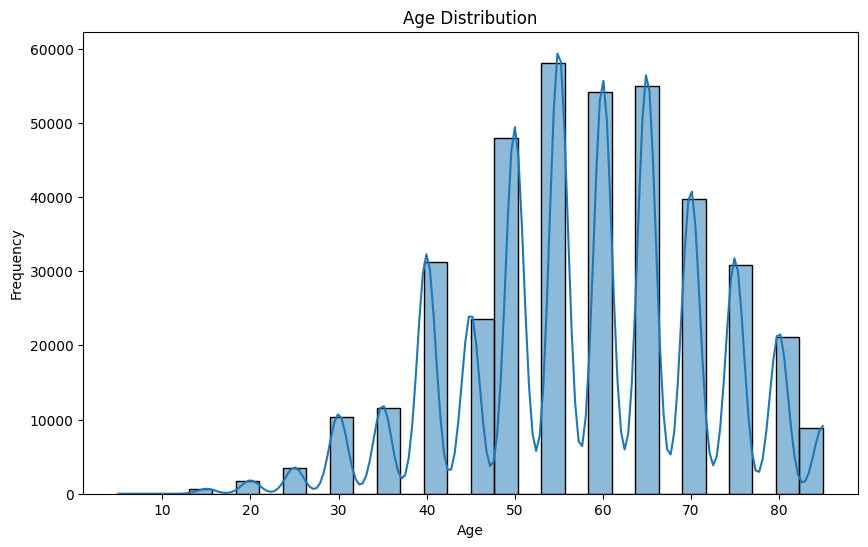

In [8]:
# 年龄分布的图
plt.figure(figsize=(10, 6))
sns.histplot(df_train['age_approx'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

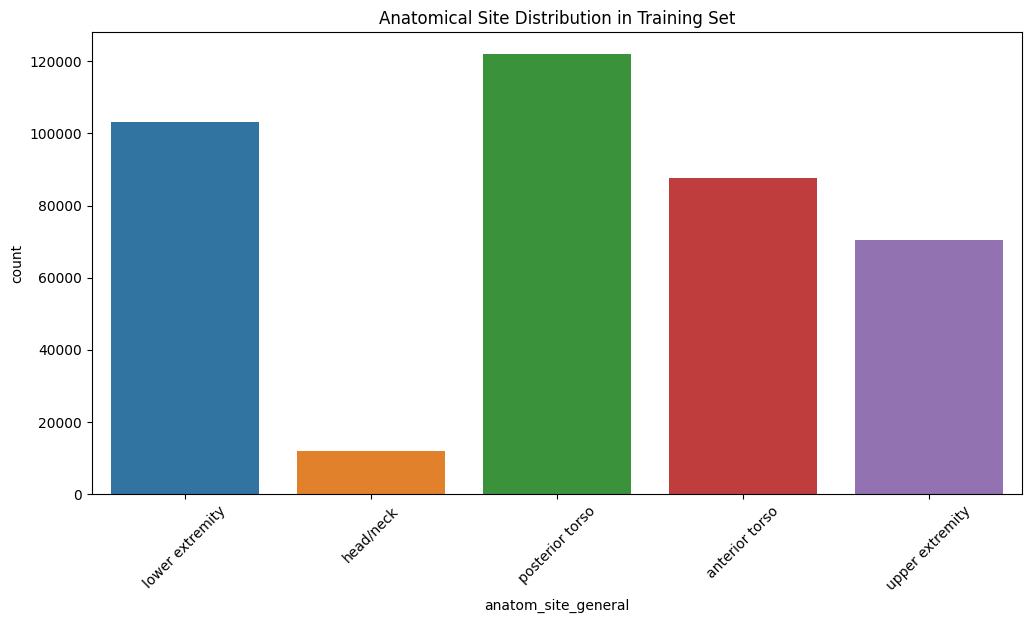

In [9]:
# 常见病变位置的分布
plt.figure(figsize=(12, 6))
sns.countplot(x='anatom_site_general', data=df_train)
plt.title('Anatomical Site Distribution in Training Set')
plt.xticks(rotation=45)
plt.show()

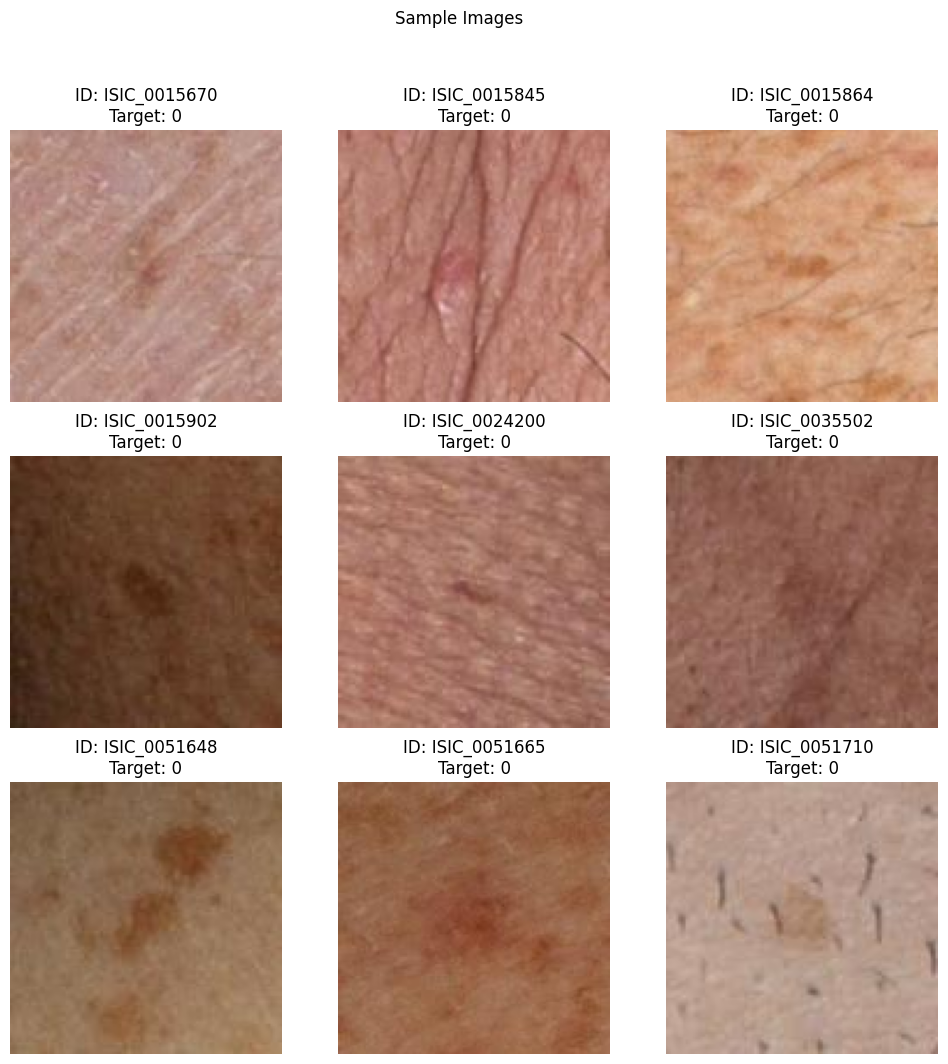

In [10]:
# Output images for example
def show_sample_images(df, title='Sample Images'):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        img_id = df['isic_id'].iloc[i]
        img_path = f"/kaggle/input/isic-2024-challenge/train-image/image/{img_id}.jpg"
        img = Image.open(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'ID: {img_id}\nTarget: {df["target"].iloc[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_sample_images(df_train)

In [11]:
df_train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')

# 打印初始数据缺失值情况
print("初始数据缺失值情况:")
print(df_train.isnull().sum())

# 删除缺失值超过50%的列
threshold = 0.5 * len(df_train)
df_train_cleaned = df_train.dropna(thresh=threshold, axis=1)

# 打印删除缺失值超过50%的列后的数据缺失值情况
print("\n删除缺失值超过50%的列后的数据缺失值情况:")
print(df_train_cleaned.isnull().sum())

# 填充age_approx的缺失值为均值
df_train_cleaned['age_approx'].fillna(df_train_cleaned['age_approx'].mean(), inplace=True)

# 填充sex的缺失值为众数
df_train_cleaned['sex'].fillna(df_train_cleaned['sex'].mode()[0], inplace=True)

# 打印填充后的数据缺失值情况
print("\n填充后的数据缺失值情况:")
print(df_train_cleaned.isnull().sum())

# 删除剩余的含有缺失值的行
df_train_cleaned = df_train_cleaned.dropna()

# 打印最终清洗后的数据缺失值情况
print("\n最终清洗后的数据缺失值情况:")
print(df_train_cleaned.isnull().sum())

/tmp/ipykernel_18/4089170287.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


初始数据缺失值情况:
isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB

/tmp/ipykernel_18/4089170287.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_cleaned['age_approx'].fillna(df_train_cleaned['age_approx'].mean(), inplace=True)
/tmp/ipykernel_18/4089170287.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cleaned['age_approx'].fillna(df_train_cleaned['age_approx'].mean(), inplace=True)

isic_id                            0
target                             0
patient_id                         0
age_approx                         0
sex                                0
anatom_site_general             5756
clin_size_long_diam_mm             0
image_type                         0
tbp_tile_type                      0
tbp_lv_A                           0
tbp_lv_Aext                        0
tbp_lv_B                           0
tbp_lv_Bext                        0
tbp_lv_C                           0
tbp_lv_Cext                        0
tbp_lv_H                           0
tbp_lv_Hext                        0
tbp_lv_L                           0
tbp_lv_Lext                        0
tbp_lv_areaMM2                     0
tbp_lv_area_perim_ratio            0
tbp_lv_color_std_mean              0
tbp_lv_deltaA                      0
tbp_lv_deltaB                      0
tbp_lv_deltaL                      0
tbp_lv_deltaLB                     0
tbp_lv_deltaLBnorm                 0
t

In [12]:
num_features = df_train.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_features = df_train.select_dtypes(include=['object']).columns.to_list()

# 移除不需要的列
unnecessary_columns = ['target', 'isic_id', 'patient_id', 'lesion_id']
num_features = [col for col in num_features if col not in unnecessary_columns]
cat_features = [col for col in cat_features if col not in unnecessary_columns]

# 定义处理数值型特征和类别型特征的处理器
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # 用mean填补缺失值
    ('scaler', StandardScaler())  # Standardize
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 用最频繁值填充缺失值
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  #
])

# 将数值型和类别型处理器组合到一起
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# 定义完整的管道
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 准备训练数据
X_train = df_train.drop(columns=unnecessary_columns)
y_train = df_train['target']

# 训练模型
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age_approx',
                                                   'clin_size_long_diam_mm',
                                                   'tbp_lv_A', 'tbp_lv_Aext',
                                                   'tbp_lv_B', 'tbp_lv_Bext',
                                                   'tbp_lv_C', 'tbp_lv_Cext',
                                                   'tbp_lv_H', 'tbp_lv_Hext',
                                                   'tbp_lv_L', 'tbp_lv_Lext',
                                                   'tbp_lv_areaMM2',
                                                   'tbp_lv_area_perim_ratio...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'anatom_site_general',
                                                   'image_type',
                                                   'tbp_tile_type',
                                                   'tbp_lv_location',
                                                   'tbp_lv_location_simple',
                                                   'attribution',
                                                   'copyright_license',
                                                   'iddx_full', 'iddx_1',
                                                   'iddx_2', 'iddx_3', 'iddx_4',
                                                   'iddx_5',
                                                   'mel_mitotic_index'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_train_pred = clf.predict(X_train)
print("训练集上的评估结果：")
print(f"准确率: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"精确率: {precision_score(y_train, y_train_pred):.4f}")
print(f"召回率: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1分数: {f1_score(y_train, y_train_pred):.4f}")
print("\n分类报告：")
print(classification_report(y_train, y_train_pred))


训练集上的评估结果：
准确率: 1.0000
精确率: 1.0000
召回率: 1.0000
F1分数: 1.0000

分类报告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400666
           1       1.00      1.00      1.00       393

    accuracy                           1.00    401059
   macro avg       1.00      1.00      1.00    401059
weighted avg       1.00      1.00      1.00    401059



In [14]:
print(set(df_train.columns) - set(df_test.columns))
print(set(df_test.columns) - set(df_train.columns))


{'lesion_id', 'target', 'mel_thick_mm', 'iddx_1', 'iddx_4', 'iddx_full', 'tbp_lv_dnn_lesion_confidence', 'iddx_3', 'iddx_5', 'mel_mitotic_index', 'iddx_2'}
set()


In [15]:
# 确认训练集和测试集都有的特征列
common_columns = list(set(df_train.columns).intersection(set(df_test.columns)))

print("训练集和测试集都有的特征列: ")
print(common_columns)


训练集和测试集都有的特征列: 
['tbp_lv_color_std_mean', 'tbp_lv_perimeterMM', 'isic_id', 'tbp_lv_C', 'tbp_lv_B', 'tbp_lv_deltaLBnorm', 'tbp_lv_norm_color', 'attribution', 'tbp_lv_stdLExt', 'tbp_lv_Lext', 'tbp_lv_nevi_confidence', 'tbp_lv_location', 'tbp_lv_Aext', 'tbp_lv_radial_color_std_max', 'tbp_lv_L', 'tbp_lv_eccentricity', 'tbp_lv_deltaLB', 'anatom_site_general', 'tbp_lv_areaMM2', 'tbp_lv_A', 'tbp_lv_Hext', 'tbp_lv_H', 'tbp_lv_location_simple', 'patient_id', 'tbp_lv_symm_2axis', 'age_approx', 'tbp_lv_norm_border', 'copyright_license', 'tbp_lv_deltaL', 'tbp_tile_type', 'tbp_lv_z', 'tbp_lv_Cext', 'tbp_lv_symm_2axis_angle', 'tbp_lv_stdL', 'clin_size_long_diam_mm', 'tbp_lv_deltaA', 'tbp_lv_area_perim_ratio', 'image_type', 'tbp_lv_y', 'tbp_lv_deltaB', 'tbp_lv_x', 'tbp_lv_Bext', 'tbp_lv_minorAxisMM', 'sex']


In [16]:
# 准备训练集和测试集的数据
X_train = df_train[common_columns]
y_train = df_train['target']

X_test = df_test[common_columns]


num_features = df_train.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_features = df_train.select_dtypes(include=['object']).columns.to_list()
num_features = [col for col in num_features if col in common_columns]
cat_features = [col for col in cat_features if col in common_columns]

# 定义数值特征和类别特征的处理管道
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # 用均值填补缺失值
    ('scaler', StandardScaler())  # 标准化
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 用最频繁值填补缺失值
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot 编码
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# 定义整个处理管道，包括特征处理和模型
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 训练模型
clf.fit(X_train, y_train)


# 使用训练好的模型对测试集进行预测
y_test_pred = clf.predict(X_test)

# 输出预测结果
print(y_test_pred)

[0 0 0]


In [17]:

df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)

# 随机打乱数据
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 计算每个split的大小
total_images = len(df)
split_size = total_images // 4

# 划分数据集
split1 = df.iloc[:split_size]
split2 = df.iloc[split_size:split_size*2]
split3 = df.iloc[split_size*2:split_size*3]
split4 = df.iloc[split_size*3:]

# 确保每个split中的图像ID是唯一的
assert split1['isic_id'].is_unique
assert split2['isic_id'].is_unique
assert split3['isic_id'].is_unique
assert split4['isic_id'].is_unique

# 确保不同split之间没有重叠
assert not split1['isic_id'].isin(split2['isic_id']).any()
assert not split1['isic_id'].isin(split3['isic_id']).any()
assert not split1['isic_id'].isin(split4['isic_id']).any()
assert not split2['isic_id'].isin(split3['isic_id']).any()
assert not split2['isic_id'].isin(split4['isic_id']).any()
assert not split3['isic_id'].isin(split4['isic_id']).any()

# 打印每个split的大小
print(f"Split 1: {len(split1)}")
print(f"Split 2: {len(split2)}")
print(f"Split 3: {len(split3)}")
print(f"Split 4: {len(split4)}")

Split 1: 100264
Split 2: 100264
Split 3: 100264
Split 4: 100267


In [18]:
# 检查训练和测试数据集的列名
print("Training Data Columns:", df_train.columns)
print("Testing Data Columns:", df_test.columns)


Training Data Columns: Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
      

In [19]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)

# 随机打乱数据
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 计算每个split的大小
total_images = len(df)
split_size = total_images // 4

# 划分数据集
split1 = df.iloc[:split_size]
split2 = df.iloc[split_size:split_size*2]
split3 = df.iloc[split_size*2:split_size*3]
split4 = df.iloc[split_size*3:]

# 确保每个split中的图像ID是唯一的
assert split1['isic_id'].is_unique
assert split2['isic_id'].is_unique
assert split3['isic_id'].is_unique
assert split4['isic_id'].is_unique

# 确保不同split之间没有重叠
assert not split1['isic_id'].isin(split2['isic_id']).any()
assert not split1['isic_id'].isin(split3['isic_id']).any()
assert not split1['isic_id'].isin(split4['isic_id']).any()
assert not split2['isic_id'].isin(split3['isic_id']).any()
assert not split2['isic_id'].isin(split4['isic_id']).any()
assert not split3['isic_id'].isin(split4['isic_id']).any()

# 打印每个split的大小
print(f"Split 1: {len(split1)}")
print(f"Split 2: {len(split2)}")
print(f"Split 3: {len(split3)}")
print(f"Split 4: {len(split4)}")





Split 1: 100264
Split 2: 100264
Split 3: 100264
Split 4: 100267


Best cutoff value: 0.31
Performance at best cutoff value:
cutoff       0.31
accuracy     1.00
precision    1.00
recall       1.00
f1           1.00
Name: 31, dtype: float64
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


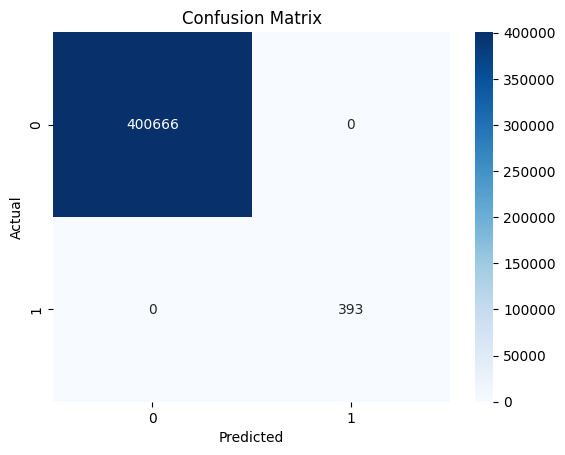

Cutoff performance data saved to 'cutoff_performance.csv'


In [20]:
num_features = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_features = df.select_dtypes(include=['object']).columns.to_list()
num_features = [col for col in num_features if col not in ['target', 'isic_id']]
cat_features = [col for col in cat_features if col not in ['isic_id']]

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 交叉验证函数
def cross_validate(train_splits, test_split):
    X_train = pd.concat(train_splits).drop(columns=['target', 'isic_id'])
    y_train = pd.concat(train_splits)['target']
    X_test = test_split.drop(columns=['target', 'isic_id'])
    y_test = test_split['target']
    
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
    return y_test, y_pred_prob

# 进行四次交叉验证
splits = [split1, split2, split3, split4]
all_true_labels = []
all_pred_probs = []

for i in range(4):
    train_splits = splits[:i] + splits[i+1:]
    test_split = splits[i]
    y_test, y_pred_prob = cross_validate(train_splits, test_split)
    all_true_labels.extend(y_test)
    all_pred_probs.extend(y_pred_prob)

# 确定最佳cutoff值
cutoff_performance = []

for cutoff in np.arange(0, 1.01, 0.01):
    pred_labels = [1 if prob >= cutoff else 0 for prob in all_pred_probs]
    accuracy = accuracy_score(all_true_labels, pred_labels)
    precision = precision_score(all_true_labels, pred_labels, zero_division=0)
    recall = recall_score(all_true_labels, pred_labels)
    f1 = f1_score(all_true_labels, pred_labels)
    cutoff_performance.append({
        'cutoff': cutoff,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

cutoff_performance = pd.DataFrame(cutoff_performance)
best_cutoff = cutoff_performance.loc[cutoff_performance['f1'].idxmax()]['cutoff']
print(f'Best cutoff value: {best_cutoff}')
print(f'Performance at best cutoff value:\n{cutoff_performance.loc[cutoff_performance["f1"].idxmax()]}')

# 使用最佳cutoff值进行预测
def predict_with_cutoff(probs, cutoff):
    return [1 if prob >= cutoff else 0 for prob in probs]

all_pred_labels = predict_with_cutoff(all_pred_probs, best_cutoff)

# 计算性能指标
accuracy = accuracy_score(all_true_labels, all_pred_labels)
precision = precision_score(all_true_labels, all_pred_labels, zero_division=0)
recall = recall_score(all_true_labels, all_pred_labels)
f1 = f1_score(all_true_labels, all_pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 绘制混淆矩阵
cm = confusion_matrix(all_true_labels, all_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 输出cutoff performance表
cutoff_performance.to_csv('cutoff_performance.csv', index=False)
print("Cutoff performance data saved to 'cutoff_performance.csv'")

The model predicts 400666 benign samples and 393 malignant samples.

In [21]:
df_train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)

# 获取共同列
common_columns = list(set(df_train.columns).intersection(set(df_test.columns)))

# 准备训练和预测数据集
X_train = df_train[common_columns]
y_train = df_train['target']
X_test = df_test[common_columns]

# 定义数值型和分类型特征
num_features = df_train.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_features = df_train.select_dtypes(include=['object']).columns.to_list()
num_features = [col for col in num_features if col in common_columns]
cat_features = [col for col in cat_features if col in common_columns]

# 定义数值和分类型特征的处理流程
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # 用均值填补缺失值
    ('scaler', StandardScaler())  # 标准化
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 用最频繁值填补缺失值
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot 编码
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# 定义完整流水线，包括预处理和逻辑回归模型
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 训练模型
clf.fit(X_train, y_train)

# 使用训练好的模型对测试集进行预测
y_test_pred_prob = clf.predict_proba(X_test)[:, 1]

# 应用最优cutoff value
best_cutoff = 0.31
y_test_pred = (y_test_pred_prob >= best_cutoff).astype(int)

# 生成submission.csv文件
df_test['target'] = y_test_pred_prob
submission = df_test[['isic_id', 'target']]
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

Submission file created successfully.
